## Explotartory Data Analysis

### Advanced Machine Learning 2023-2

### Import libraries

In [312]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from IPython.display import display
sns.set_style("darkgrid")

### Raw Data Structure

This CheXpert small version, contains a tran and test split. Each directory, contains a sub-directory refering to each patient. Under the patient, are multiple (or single) directories referring to each study. Under each studty, there is an xray image, and it it's name contains the type of view. 

- CheXpert Small Version
    * Train Split
        * Patient 1
            * Study 1
                * X-ray Image (Type of View)
            * Study 2
                * X-ray Image (Type of View)
            
...

Regarding the lables, there is an original label that came with the CheXpert dataset, but some Standford researchers (same group as the original CheXpert), developed a model for labeling again the data based on a Biomedical pre-trained BERT model, with the images and the lables. After validating this model, they created a new label file. This gave substantial better results in the classification task on the models trained with this new GT. This is called train_VisualChex**b**ert



Match in train!
Match in test!


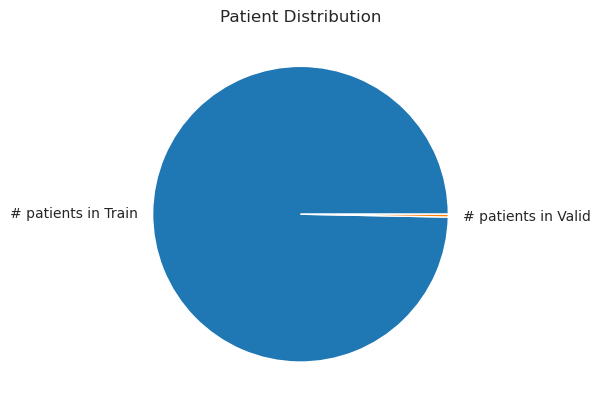

In [313]:
# Get path for raw data
raw_data_path = os.path.join(os.getcwd().split('notebooks')[0],'data','raw','CheXpert-v1.0-small')

# Get amount of patients in train
train_patient_folders = os.listdir(os.path.join(raw_data_path,'train'))
test_patient_folders = os.listdir(os.path.join(raw_data_path,'valid'))

# Load labels
train_df = pd.read_csv(os.path.join(raw_data_path,'train.csv'))
test_df = pd.read_csv(os.path.join(raw_data_path,'valid.csv'))

# Check if the number of patients directory is the same in .csv as in the folders
if len(train_df['Path'].str.split('study').str[0].unique()) == len(train_patient_folders):
    print('Match in train!')
if len(test_df['Path'].str.split('study').str[0].unique()) == len(test_patient_folders):
    print('Match in test!')

# Graph results
plt.pie([len(train_patient_folders),len(test_patient_folders)],labels = ['# patients in Train','# patients in Valid'])
plt.title('Patient Distribution')
plt.show()

### Check Sex Distribution

Male       132636
Female      90777
Unknown         1
Name: Sex, dtype: int64

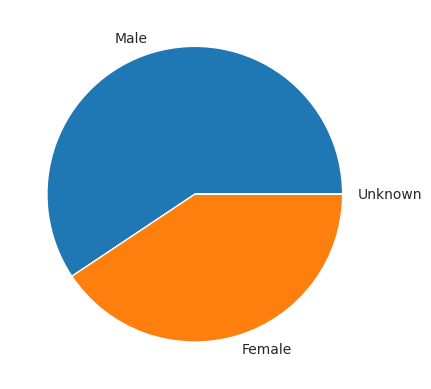

In [314]:
plt.pie(x = train_df['Sex'].value_counts(),labels = ['Male','Female','Unknown'])
train_df['Sex'].value_counts()

### Images and Studies Distributions

In [283]:
num_studies = []
num_images = []
for patient in train_patient_folders:
    studies = os.listdir(os.path.join(raw_data_path,'train',patient))
    num_studies.append(len(studies))
    sum_images = 0
    for study in studies:
        images = os.listdir(os.path.join(raw_data_path,'train',patient,study))        
        sum_images += len(images)
    num_images.append(sum_images)

Text(0, 0.5, 'Count')

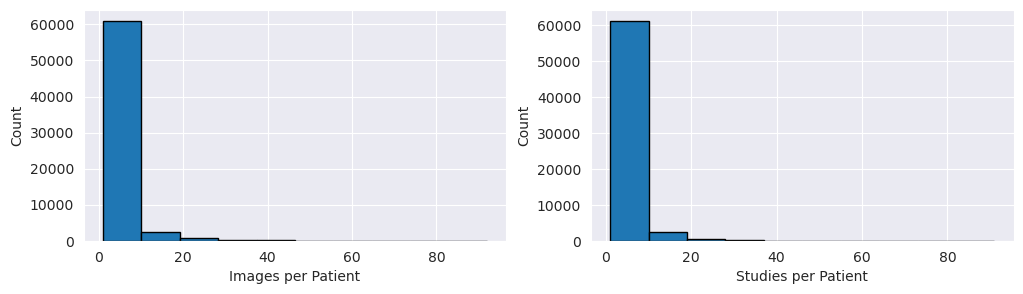

In [315]:
fig,ax = plt.subplots(1,2,figsize = (12,3))
ax[0].hist(num_images,edgecolor= 'black')
ax[0].set_xlabel('Images per Patient')
ax[0].set_ylabel('Count')

ax[1].hist(num_studies,edgecolor= 'black')
ax[1].set_xlabel('Studies per Patient')
ax[1].set_ylabel('Count')


### Vectors of proportions

For this study, we will create different proportions of data depending on the sex. With this subgroups, we will again trian the models and evaluate the results with cross-validation. But before doing so, it is important to note the relation between the detected pathologies and the sex. 

In [316]:
# Read chexbert
chexbert = '/home/juandres/aml/CheXBias/data/raw/CheXpert-v1.0-small/train_VisualCheXbert.csv'
df = pd.read_csv(chexbert)
df = df[df['Sex'] != 'Unknown']

# Count number of male and females

# Number of instances 
num_positive_instances = df.groupby('Sex').sum()
num_instances = df.groupby('Sex').count()

# Percentage of presence
perc_presence = num_positive_instances/num_instances

/tmp/ipykernel_1020923/2959209466.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  num_positive_instances = df.groupby('Sex').sum()


<Axes: xlabel='Occurrence', ylabel='Pathology'>

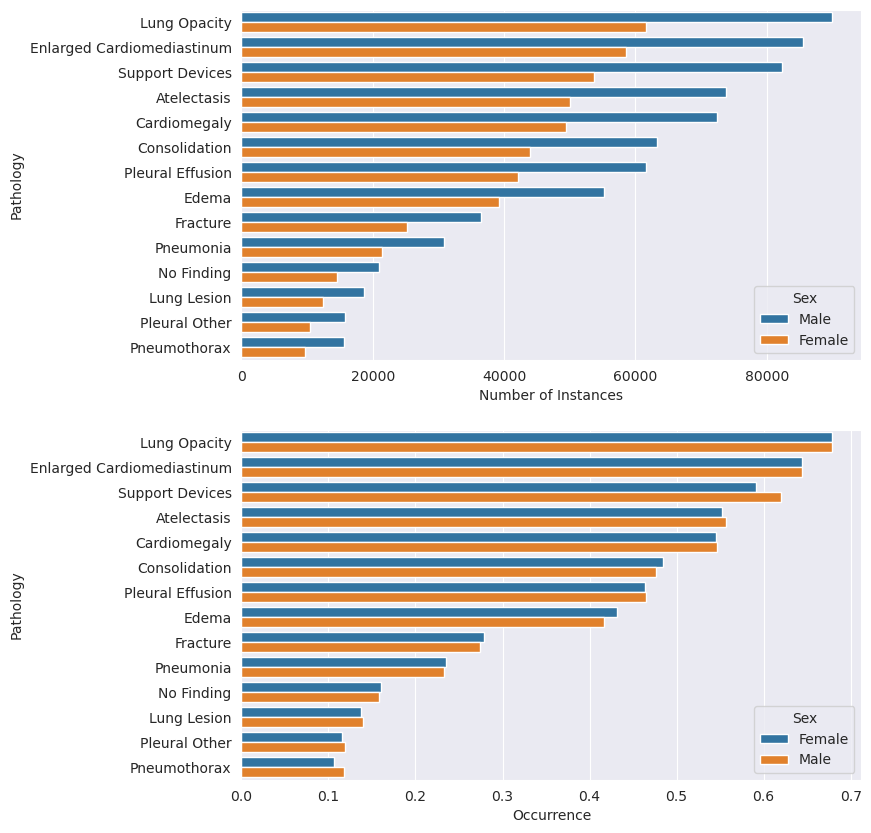

In [319]:
#columns_to_drop
num_positive_instances_by_sex = num_positive_instances.reset_index().drop(columns='Age').melt('Sex',var_name='Pathology',value_name='Number of Instances')
normalize_occurrence_by_sex = perc_presence.reset_index().drop(columns=['Age','AP/PA','Frontal/Lateral','Path']).melt('Sex',var_name='Pathology',value_name='Occurrence')

fig,ax = plt.subplots(2,1,figsize = (8,10))
sns.barplot(data = num_positive_instances_by_sex.sort_values('Number of Instances',ascending=False), y = 'Pathology',x = 'Number of Instances', hue = 'Sex',ax = ax[0])
sns.barplot(data = normalize_occurrence_by_sex.sort_values('Occurrence',ascending=False), y = 'Pathology',x = 'Occurrence', hue = 'Sex',ax = ax[1])


Even though this results aren't yet tested with statistical support, it can be seen the huge difference between the presence in number in instances of all the pathologies vs the ocurrence of it in % separating by Sex. With this in mind, a random resampling of the data woldn't affet the distribution of pathologies, avoiding the increment of bias per class accuracy due to the sub-grouping. 